# ***ResNet28*** on CIFAR-10 dataset for classification

## Importing libraries and modules

In [14]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torch.optim import Adam, SGD
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import os
from torchvision.transforms import v2
from tqdm import tqdm 

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 4070 SUPER


## *Double Convolution Block* (VGG-like)

<p align="center">
  <img src="Images/ResBlock.png" alt="ResBlock" width="600"/> <br>
  <em> ResBlock </em>
</p>

In [ ]:
class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, identity_downsample = None, stride = 1):
        super(Block,self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride = stride, padding = 1), #For changes in spatial size (Downsample)
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding = 1),
            nn.BatchNorm2d(out_channels)
        )
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
    
    def forward (self, x):
        identity = x.clone()
        x = self.model(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        
        x+= identity #Residual connection
        x = self.relu(x)
        return x

## Function that *builds one stage* (layer group) of a ResNet-like architecture.

- Mismatch in channel dimension between identity mapping and feature map is resolved using `identity_downsample`.
- While, mismatch in spatial dimension is being handled by the first *Double Convolution block* of the stage with stride = 2, which would shrink the map by half.

In [ ]:
def make_layer_ (ResBlock, num_blocks, in_channels, out_channels, stride = 1):
    identity_downsample = None
    layers = []
    if stride!= 1 or in_channels !=  out_channels:
        identity_downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride = stride),
            nn.BatchNorm2d(out_channels)
        )
    layers.append(ResBlock(in_channels,out_channels, identity_downsample = identity_downsample, stride = stride)) #The first block of the stage is for spatial downsampling
    for i in range (num_blocks-1):
        layers.append(ResBlock(out_channels,out_channels))
    return nn.Sequential(*layers)

## ResNet model (For lighter versions of ResNet)

In [ ]:
class ResNet_lite(nn.Module):
    def __init__ (self, ResBlock, block_list, num_classes, num_channels = 3, planes = [16,32,64]):
        super(ResNet_lite, self).__init__()
        self.planes = planes

        self.layer1 = make_layer_(ResBlock, block_list[0], num_channels, self.planes[0])

        self.layers = nn.ModuleList()
        for i in range (1,len(block_list)):
            layer = make_layer_(ResBlock, block_list[i], self.planes[i-1], self.planes[i], stride =2)
            self.layers.append(layer)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.planes[len(planes)-1], num_classes)

    def forward(self,x):
        x = self.layer1(x)
        for layer in self.layers: 
            x = layer(x)
        x = self.avg_pool(x)
        x = x.reshape(x.shape[0], -1) #Flatten the tensor of 4 dimensions [B,C,1,1] to [B,C] of 2 dimensions including the batch size
        x = self.fc(x)
        return x
    
    def train_batch(self, x, y, optimizer, loss_fn):
        self.train()
        prediction = self(x) #same as self.forward(x)
        batch_loss = loss_fn(prediction, y)
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return batch_loss.item(), prediction

In [ ]:
data_folder = './data_temp/CIFAR10' 
if (not os.path.exists(data_folder)):
    data_folder = './data_temp/CIFAR10' 

'''Labels' names'''
cifar_labels = {
    0: "Airplane",
    1: "Automobile",
    2: "Bird",
    3: "Cat",
    4: "Deer",
    5: "Dog",
    6: "Frog",
    7: "Horse",
    8: "Ship",
    9: "Truck"
}

## Loading CIFAR10 dataset and data augmentation

In [7]:

img_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32,scale= True),
    v2.Normalize(mean=[0.5,0.5,0.5], std = [0.5,0.5,0.5])
])

aug_transform = v2.Compose([
    v2.RandomHorizontalFlip(),
    v2.RandomCrop(32, padding=4),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale = True),
    v2.Normalize(mean = [0.5,0.5,0.5], std = [0.5,0.5,0.5]) #To make the new data, mean ~ 0 and standard deviation ~ 1
])

def load_data(data_augmentaion = False):
    #Train dataset
    if data_augmentaion:
        train_data = datasets.CIFAR10(data_folder, download = False, train = True, transform = aug_transform) #AUGMENTED DATASET
    else:  
        train_data = datasets.CIFAR10(data_folder, download = True, train = True, transform = img_transform)
    #Test dataset
    val_cifar = datasets.CIFAR10(data_folder, download = True, train = False, transform = img_transform)
    #DataLoader
    trn_dl = DataLoader(train_data, batch_size = 128, shuffle = True, num_workers=0, pin_memory=True)
    eval_dl = DataLoader(val_cifar, batch_size = 512, shuffle = False)
    return trn_dl, eval_dl

In [ ]:
def get_model(ResNet, device = 'cuda', lr = 1e-3, weight_decay = 1e-5, optim = 'adam'):
     model = ResNet().to(device)
     loss_fn = nn.CrossEntropyLoss()
     if optim == 'adam':
          optimizer = Adam(model.parameters(), lr = lr, weight_decay = weight_decay) 
     elif optim == 'SGD':
          optimizer = SGD(model.parameters(), momentum=0.9, nesterov=True,lr = 0.01, weight_decay=1e-4) #SGD with momentum Beta = 0.9
     else: raise ValueError('Unsupported Optimizer')
     return model, loss_fn, optimizer

'''Denormalize to visualize outputs'''
def denormalize(tensor):
     mean = torch.tensor([0.5,0.5,0.5]).view(3,1,1) #3 channels and 1x1 tensor(scalar) for the nmean
     std = torch.tensor([0.5,0.5,0.5]).view(3,1,1)
     return tensor*std +mean

'''Metric to evaluate output'''
def accuracy(prediction, y):
     argmaxes = prediction.max(-1)[1] #since prediction.max(-1) returns the maximum value of the last dimension and the index of that, argmax
     is_correct = (argmaxes == y)
     return is_correct.cpu().numpy().tolist()

## ResNet Model
- Model is named "ResNet28", because it is reduced 3 layers of double convolution with 512 channels from the ResNet34, hence given the namne.

In [ ]:
def ResNet28 (num_classes = 10, num_channels = 3): 
    block_list = [4,4,4]
    return ResNet_lite(Block, block_list, num_classes, num_channels, [64,128,256])

## *Training*

Files already downloaded and verified


CURRENT EPOCH: 0: 100%|██████████| 391/391 [00:28<00:00, 13.62it/s]


Epoch's loss: 1.3615, epoch's accuracy = 49.8280%


CURRENT EPOCH: 1: 100%|██████████| 391/391 [00:28<00:00, 13.79it/s]


Epoch's loss: 0.9334, epoch's accuracy = 66.7760%


CURRENT EPOCH: 2: 100%|██████████| 391/391 [00:28<00:00, 13.79it/s]


Epoch's loss: 0.7317, epoch's accuracy = 74.3080%


CURRENT EPOCH: 3: 100%|██████████| 391/391 [00:28<00:00, 13.83it/s]


Epoch's loss: 0.6149, epoch's accuracy = 78.5700%


CURRENT EPOCH: 4: 100%|██████████| 391/391 [00:28<00:00, 13.76it/s]


Epoch's loss: 0.5434, epoch's accuracy = 81.1080%


CURRENT EPOCH: 5: 100%|██████████| 391/391 [00:28<00:00, 13.64it/s]


Epoch's loss: 0.4865, epoch's accuracy = 83.3180%


CURRENT EPOCH: 6: 100%|██████████| 391/391 [00:28<00:00, 13.56it/s]


Epoch's loss: 0.4408, epoch's accuracy = 84.6780%


CURRENT EPOCH: 7: 100%|██████████| 391/391 [00:39<00:00,  9.91it/s]


Epoch's loss: 0.4061, epoch's accuracy = 86.0180%


CURRENT EPOCH: 8: 100%|██████████| 391/391 [00:41<00:00,  9.50it/s]


Epoch's loss: 0.3802, epoch's accuracy = 86.8280%


CURRENT EPOCH: 9: 100%|██████████| 391/391 [00:42<00:00,  9.29it/s]


Epoch's loss: 0.3522, epoch's accuracy = 87.8320%


CURRENT EPOCH: 10: 100%|██████████| 391/391 [00:41<00:00,  9.33it/s]


Epoch's loss: 0.3355, epoch's accuracy = 88.5080%


CURRENT EPOCH: 11: 100%|██████████| 391/391 [00:42<00:00,  9.26it/s]


Epoch's loss: 0.3149, epoch's accuracy = 89.1780%


CURRENT EPOCH: 12: 100%|██████████| 391/391 [00:41<00:00,  9.33it/s]


Epoch's loss: 0.3046, epoch's accuracy = 89.4600%


CURRENT EPOCH: 13: 100%|██████████| 391/391 [00:41<00:00,  9.38it/s]


Epoch's loss: 0.2817, epoch's accuracy = 90.2300%


CURRENT EPOCH: 14: 100%|██████████| 391/391 [00:41<00:00,  9.41it/s]


Epoch's loss: 0.2762, epoch's accuracy = 90.3340%


CURRENT EPOCH: 15: 100%|██████████| 391/391 [00:41<00:00,  9.51it/s]


Epoch's loss: 0.2603, epoch's accuracy = 90.9560%


CURRENT EPOCH: 16: 100%|██████████| 391/391 [00:44<00:00,  8.71it/s]


Epoch's loss: 0.2472, epoch's accuracy = 91.3420%


CURRENT EPOCH: 17: 100%|██████████| 391/391 [00:46<00:00,  8.50it/s]


Epoch's loss: 0.2384, epoch's accuracy = 91.5640%


CURRENT EPOCH: 18: 100%|██████████| 391/391 [00:41<00:00,  9.32it/s]


Epoch's loss: 0.2311, epoch's accuracy = 92.0120%


CURRENT EPOCH: 19: 100%|██████████| 391/391 [00:40<00:00,  9.72it/s]


Epoch's loss: 0.2204, epoch's accuracy = 92.3060%


CURRENT EPOCH: 20: 100%|██████████| 391/391 [00:39<00:00,  9.80it/s]


Epoch's loss: 0.2096, epoch's accuracy = 92.7220%


CURRENT EPOCH: 21: 100%|██████████| 391/391 [00:41<00:00,  9.38it/s]


Epoch's loss: 0.2064, epoch's accuracy = 92.7720%


CURRENT EPOCH: 22: 100%|██████████| 391/391 [00:40<00:00,  9.54it/s]


Epoch's loss: 0.1931, epoch's accuracy = 93.0960%


CURRENT EPOCH: 23: 100%|██████████| 391/391 [00:41<00:00,  9.45it/s]


Epoch's loss: 0.1901, epoch's accuracy = 93.3140%


CURRENT EPOCH: 24: 100%|██████████| 391/391 [00:40<00:00,  9.59it/s]


Epoch's loss: 0.1784, epoch's accuracy = 93.9040%


CURRENT EPOCH: 25: 100%|██████████| 391/391 [00:40<00:00,  9.57it/s]


Epoch's loss: 0.1775, epoch's accuracy = 93.7720%


CURRENT EPOCH: 26: 100%|██████████| 391/391 [00:41<00:00,  9.46it/s]


Epoch's loss: 0.1694, epoch's accuracy = 94.0600%


CURRENT EPOCH: 27: 100%|██████████| 391/391 [00:41<00:00,  9.31it/s]


Epoch's loss: 0.1607, epoch's accuracy = 94.4280%


CURRENT EPOCH: 28: 100%|██████████| 391/391 [00:41<00:00,  9.37it/s]


Epoch's loss: 0.1571, epoch's accuracy = 94.6320%


CURRENT EPOCH: 29: 100%|██████████| 391/391 [00:42<00:00,  9.29it/s]


Epoch's loss: 0.1526, epoch's accuracy = 94.5660%


CURRENT EPOCH: 30: 100%|██████████| 391/391 [00:41<00:00,  9.36it/s]


Epoch's loss: 0.1443, epoch's accuracy = 94.9980%


CURRENT EPOCH: 31: 100%|██████████| 391/391 [00:42<00:00,  9.26it/s]


Epoch's loss: 0.1482, epoch's accuracy = 94.7900%


CURRENT EPOCH: 32: 100%|██████████| 391/391 [00:41<00:00,  9.41it/s]


Epoch's loss: 0.1389, epoch's accuracy = 95.1000%


CURRENT EPOCH: 33: 100%|██████████| 391/391 [00:30<00:00, 13.02it/s]


Epoch's loss: 0.1272, epoch's accuracy = 95.5920%


CURRENT EPOCH: 34: 100%|██████████| 391/391 [00:28<00:00, 13.51it/s]


Epoch's loss: 0.1341, epoch's accuracy = 95.4400%


CURRENT EPOCH: 35: 100%|██████████| 391/391 [00:28<00:00, 13.73it/s]


Epoch's loss: 0.1244, epoch's accuracy = 95.6440%


CURRENT EPOCH: 36: 100%|██████████| 391/391 [00:28<00:00, 13.81it/s]


Epoch's loss: 0.1252, epoch's accuracy = 95.5840%


CURRENT EPOCH: 37: 100%|██████████| 391/391 [00:28<00:00, 13.84it/s]


Epoch's loss: 0.1203, epoch's accuracy = 95.7580%


CURRENT EPOCH: 38: 100%|██████████| 391/391 [00:28<00:00, 13.75it/s]


Epoch's loss: 0.1148, epoch's accuracy = 96.0260%


CURRENT EPOCH: 39: 100%|██████████| 391/391 [00:28<00:00, 13.81it/s]


Epoch's loss: 0.1134, epoch's accuracy = 96.0280%


CURRENT EPOCH: 40: 100%|██████████| 391/391 [00:28<00:00, 13.78it/s]


Epoch's loss: 0.1091, epoch's accuracy = 96.2740%


CURRENT EPOCH: 41: 100%|██████████| 391/391 [00:28<00:00, 13.86it/s]


Epoch's loss: 0.1082, epoch's accuracy = 96.2200%


CURRENT EPOCH: 42: 100%|██████████| 391/391 [00:28<00:00, 13.87it/s]


Epoch's loss: 0.1090, epoch's accuracy = 96.1540%


CURRENT EPOCH: 43: 100%|██████████| 391/391 [00:28<00:00, 13.90it/s]


Epoch's loss: 0.1044, epoch's accuracy = 96.3400%


CURRENT EPOCH: 44: 100%|██████████| 391/391 [00:28<00:00, 13.81it/s]


Epoch's loss: 0.1017, epoch's accuracy = 96.4920%


CURRENT EPOCH: 45: 100%|██████████| 391/391 [00:28<00:00, 13.86it/s]


Epoch's loss: 0.1029, epoch's accuracy = 96.4580%


CURRENT EPOCH: 46: 100%|██████████| 391/391 [00:28<00:00, 13.82it/s]


Epoch's loss: 0.0947, epoch's accuracy = 96.6920%


CURRENT EPOCH: 47: 100%|██████████| 391/391 [00:28<00:00, 13.84it/s]


Epoch's loss: 0.0946, epoch's accuracy = 96.7000%


CURRENT EPOCH: 48: 100%|██████████| 391/391 [00:28<00:00, 13.86it/s]


Epoch's loss: 0.0971, epoch's accuracy = 96.5660%


CURRENT EPOCH: 49: 100%|██████████| 391/391 [00:28<00:00, 13.73it/s]


Epoch's loss: 0.0888, epoch's accuracy = 96.8660%


CURRENT EPOCH: 50: 100%|██████████| 391/391 [00:28<00:00, 13.76it/s]


Epoch's loss: 0.0909, epoch's accuracy = 96.8560%


CURRENT EPOCH: 51: 100%|██████████| 391/391 [00:28<00:00, 13.70it/s]


Epoch's loss: 0.0936, epoch's accuracy = 96.8500%


CURRENT EPOCH: 52: 100%|██████████| 391/391 [00:28<00:00, 13.79it/s]


Epoch's loss: 0.0892, epoch's accuracy = 96.8140%


CURRENT EPOCH: 53: 100%|██████████| 391/391 [00:28<00:00, 13.73it/s]


Epoch's loss: 0.0885, epoch's accuracy = 96.8440%


CURRENT EPOCH: 54: 100%|██████████| 391/391 [00:28<00:00, 13.76it/s]


Epoch's loss: 0.0846, epoch's accuracy = 97.0300%


CURRENT EPOCH: 55: 100%|██████████| 391/391 [00:28<00:00, 13.87it/s]


Epoch's loss: 0.0859, epoch's accuracy = 97.0360%


CURRENT EPOCH: 56: 100%|██████████| 391/391 [00:28<00:00, 13.85it/s]


Epoch's loss: 0.0785, epoch's accuracy = 97.3520%


CURRENT EPOCH: 57: 100%|██████████| 391/391 [00:28<00:00, 13.82it/s]


Epoch's loss: 0.0854, epoch's accuracy = 97.0180%


CURRENT EPOCH: 58: 100%|██████████| 391/391 [00:28<00:00, 13.81it/s]


Epoch's loss: 0.0811, epoch's accuracy = 97.1360%


CURRENT EPOCH: 59: 100%|██████████| 391/391 [00:28<00:00, 13.75it/s]


Epoch's loss: 0.0814, epoch's accuracy = 97.2600%


CURRENT EPOCH: 60: 100%|██████████| 391/391 [00:28<00:00, 13.85it/s]


Epoch's loss: 0.0813, epoch's accuracy = 97.2080%


CURRENT EPOCH: 61: 100%|██████████| 391/391 [00:28<00:00, 13.81it/s]


Epoch's loss: 0.0765, epoch's accuracy = 97.3620%


CURRENT EPOCH: 62: 100%|██████████| 391/391 [00:28<00:00, 13.79it/s]


Epoch's loss: 0.0744, epoch's accuracy = 97.4340%


CURRENT EPOCH: 63: 100%|██████████| 391/391 [00:28<00:00, 13.76it/s]


Epoch's loss: 0.0706, epoch's accuracy = 97.5380%


CURRENT EPOCH: 64: 100%|██████████| 391/391 [00:28<00:00, 13.80it/s]


Epoch's loss: 0.0732, epoch's accuracy = 97.4820%


CURRENT EPOCH: 65: 100%|██████████| 391/391 [00:28<00:00, 13.81it/s]


Epoch's loss: 0.0647, epoch's accuracy = 97.8040%


CURRENT EPOCH: 66: 100%|██████████| 391/391 [00:28<00:00, 13.79it/s]


Epoch's loss: 0.0676, epoch's accuracy = 97.6260%


CURRENT EPOCH: 67: 100%|██████████| 391/391 [00:28<00:00, 13.81it/s]


Epoch's loss: 0.0680, epoch's accuracy = 97.6260%


CURRENT EPOCH: 68: 100%|██████████| 391/391 [00:28<00:00, 13.85it/s]


Epoch's loss: 0.0660, epoch's accuracy = 97.7520%


CURRENT EPOCH: 69: 100%|██████████| 391/391 [00:28<00:00, 13.87it/s]


Epoch's loss: 0.0598, epoch's accuracy = 97.8860%


CURRENT EPOCH: 70: 100%|██████████| 391/391 [00:28<00:00, 13.89it/s]


Epoch's loss: 0.0599, epoch's accuracy = 97.9740%


CURRENT EPOCH: 71: 100%|██████████| 391/391 [00:28<00:00, 13.85it/s]


Epoch's loss: 0.0641, epoch's accuracy = 97.7080%


CURRENT EPOCH: 72: 100%|██████████| 391/391 [00:28<00:00, 13.77it/s]


Epoch's loss: 0.0612, epoch's accuracy = 97.8400%


CURRENT EPOCH: 73: 100%|██████████| 391/391 [00:28<00:00, 13.86it/s]


Epoch's loss: 0.0543, epoch's accuracy = 98.0600%


CURRENT EPOCH: 74: 100%|██████████| 391/391 [00:28<00:00, 13.75it/s]


Epoch's loss: 0.0616, epoch's accuracy = 97.7860%


CURRENT EPOCH: 75: 100%|██████████| 391/391 [00:28<00:00, 13.79it/s]


Epoch's loss: 0.0557, epoch's accuracy = 98.0380%


CURRENT EPOCH: 76: 100%|██████████| 391/391 [00:28<00:00, 13.71it/s]


Epoch's loss: 0.0560, epoch's accuracy = 98.0660%


CURRENT EPOCH: 77: 100%|██████████| 391/391 [00:28<00:00, 13.78it/s]


Epoch's loss: 0.0583, epoch's accuracy = 97.9140%


CURRENT EPOCH: 78: 100%|██████████| 391/391 [00:28<00:00, 13.75it/s]


Epoch's loss: 0.0509, epoch's accuracy = 98.2560%


CURRENT EPOCH: 79: 100%|██████████| 391/391 [00:28<00:00, 13.82it/s]


Epoch's loss: 0.0553, epoch's accuracy = 98.1200%


CURRENT EPOCH: 80: 100%|██████████| 391/391 [00:28<00:00, 13.84it/s]


Epoch's loss: 0.0505, epoch's accuracy = 98.3240%


CURRENT EPOCH: 81: 100%|██████████| 391/391 [00:28<00:00, 13.96it/s]


Epoch's loss: 0.0548, epoch's accuracy = 98.0980%


CURRENT EPOCH: 82: 100%|██████████| 391/391 [00:28<00:00, 13.96it/s]


Epoch's loss: 0.0490, epoch's accuracy = 98.2560%


CURRENT EPOCH: 83: 100%|██████████| 391/391 [00:28<00:00, 13.94it/s]


Epoch's loss: 0.0564, epoch's accuracy = 98.1520%


CURRENT EPOCH: 84: 100%|██████████| 391/391 [00:28<00:00, 13.89it/s]


Epoch's loss: 0.0527, epoch's accuracy = 98.2420%


CURRENT EPOCH: 85: 100%|██████████| 391/391 [00:28<00:00, 13.79it/s]


Epoch's loss: 0.0481, epoch's accuracy = 98.3280%


CURRENT EPOCH: 86: 100%|██████████| 391/391 [00:28<00:00, 13.89it/s]


Epoch's loss: 0.0468, epoch's accuracy = 98.3700%


CURRENT EPOCH: 87: 100%|██████████| 391/391 [00:28<00:00, 13.72it/s]


Epoch's loss: 0.0524, epoch's accuracy = 98.2460%


CURRENT EPOCH: 88: 100%|██████████| 391/391 [00:28<00:00, 13.83it/s]


Epoch's loss: 0.0479, epoch's accuracy = 98.3840%


CURRENT EPOCH: 89: 100%|██████████| 391/391 [00:28<00:00, 13.79it/s]


Epoch's loss: 0.0492, epoch's accuracy = 98.3700%


CURRENT EPOCH: 90: 100%|██████████| 391/391 [00:28<00:00, 13.83it/s]


Epoch's loss: 0.0463, epoch's accuracy = 98.4720%


CURRENT EPOCH: 91: 100%|██████████| 391/391 [00:28<00:00, 13.75it/s]


Epoch's loss: 0.0523, epoch's accuracy = 98.2220%


CURRENT EPOCH: 92: 100%|██████████| 391/391 [00:28<00:00, 13.80it/s]


Epoch's loss: 0.0452, epoch's accuracy = 98.4280%


CURRENT EPOCH: 93: 100%|██████████| 391/391 [00:28<00:00, 13.83it/s]


Epoch's loss: 0.0500, epoch's accuracy = 98.3260%


CURRENT EPOCH: 94: 100%|██████████| 391/391 [00:28<00:00, 13.89it/s]


Epoch's loss: 0.0462, epoch's accuracy = 98.3920%


CURRENT EPOCH: 95: 100%|██████████| 391/391 [00:28<00:00, 13.86it/s]


Epoch's loss: 0.0408, epoch's accuracy = 98.5400%


CURRENT EPOCH: 96: 100%|██████████| 391/391 [00:28<00:00, 13.90it/s]


Epoch's loss: 0.0445, epoch's accuracy = 98.4720%


CURRENT EPOCH: 97: 100%|██████████| 391/391 [00:28<00:00, 13.80it/s]


Epoch's loss: 0.0480, epoch's accuracy = 98.3500%


CURRENT EPOCH: 98: 100%|██████████| 391/391 [00:28<00:00, 13.82it/s]


Epoch's loss: 0.0445, epoch's accuracy = 98.4760%


CURRENT EPOCH: 99: 100%|██████████| 391/391 [30:47<00:00,  4.72s/it]   

Epoch's loss: 0.0407, epoch's accuracy = 98.6960%


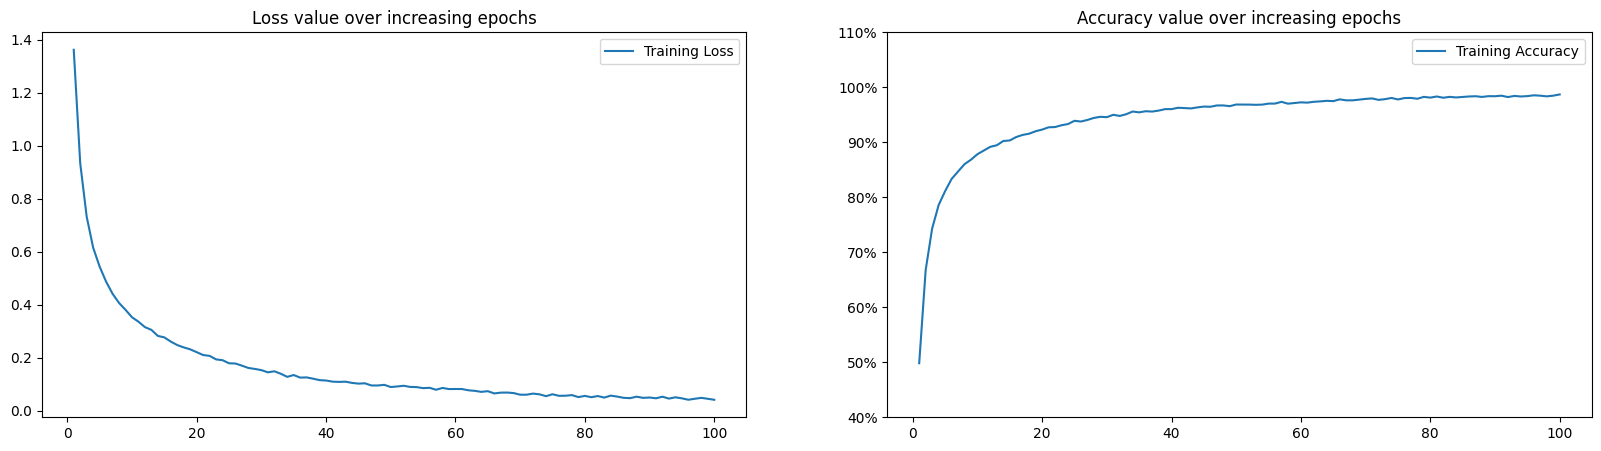

In [13]:
trn_dl, eval_dl = load_data(data_augmentaion=True)
model, loss_fn, optimizer = get_model(ResNet=ResNet28)
train_losses, train_accuracies = [],[]
eval_losses, eval_accuracies = [],[]

epochs = 100

scheduler = lr_scheduler.LinearLR(optimizer=optimizer,start_factor=0.1, end_factor = 1, total_iters= 60 )
model.train()

for epoch in range (epochs):
    epoch_losses, epoch_accuracies = [],[]

    for batch in tqdm(trn_dl, desc=f'CURRENT EPOCH: {epoch}'):
        x,y = batch
        x,y = x.to(device), y.to(device)
        batch_loss, prediction = model.train_batch(x,y,optimizer=optimizer, loss_fn=loss_fn)
        
        #For storing intermediate values of loss and accuracy 
        epoch_losses.append(batch_loss) #append is used to add an object to the list, here the batch_loss is a scalar
        is_correct = accuracy(prediction, y)
        epoch_accuracies.extend(is_correct) #extend is used here, because it combines list, is_correct here is a list of 0 and 1, `extend` requires soemthig iterable, a float scalar is not iterable

    scheduler.step() 
    #Computation of the average loss and accuracy of one epoch
    epoch_loss = np.array(epoch_losses).mean() #`np.array()` used to ensure that the list is a numpy array of values
    epoch_acc = np.array(epoch_accuracies).mean()

    print(f'Epoch\'s loss: {epoch_loss:.4f}, epoch\'s accuracy = {(epoch_acc*100):.4f}%')
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

iter=np.arange(epochs)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(iter, train_losses, label='Training Loss')
plt.legend()
plt.subplot(122) 
plt.title('Accuracy value over increasing epochs')
plt.plot(iter, train_accuracies, label='Training Accuracy')

ax = plt.gca()
ticks = ax.get_yticks()
ax.set_yticks(ticks)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()    
    

## *Evaluation*

In [16]:
all_eval_correct = []
val_cifar = datasets.CIFAR10(data_folder, download = True, train = False, transform= img_transform)

'''Running on the evaluation dataset'''
model.eval()
for ix, batch in enumerate(eval_dl):
    x,y = batch
    x,y = x.to(device), y.to(device)
    prediction = model(x)
    eval_is_correct = accuracy(prediction, y)
    all_eval_correct.extend(eval_is_correct)
eval_accuracy = np.mean(all_eval_correct)*100
print(f'The accuracy of the ResNet model on the evaluation dataset is {eval_accuracy:.4f}%')

Files already downloaded and verified
The accuracy of the ResNet model on the evaluation dataset is 92.6400%


### Visualization on the classified output


 RANDOM 200 IMAGES ILLUSTRATION TEST

Image 3683 is wrong, true label: Ship and predicted label: Bird
Image 7341 is wrong, true label: Deer and predicted label: Dog
Image 9587 is wrong, true label: Horse and predicted label: Dog
Image 7005 is wrong, true label: Automobile and predicted label: Truck
Image 7913 is wrong, true label: Ship and predicted label: Airplane
Image 8084 is wrong, true label: Dog and predicted label: Cat
Image 4650 is wrong, true label: Frog and predicted label: Cat
Image 3762 is wrong, true label: Automobile and predicted label: Truck
Image 8022 is wrong, true label: Bird and predicted label: Cat
Image 9857 is wrong, true label: Airplane and predicted label: Ship
Image 5830 is wrong, true label: Dog and predicted label: Cat
Image 147 is wrong, true label: Bird and predicted label: Dog
Image 6569 is wrong, true label: Ship and predicted label: Airplane
Image 2854 is wrong, true label: Truck and predicted label: Automobile
Correct predictions: 186 / 200
The accura

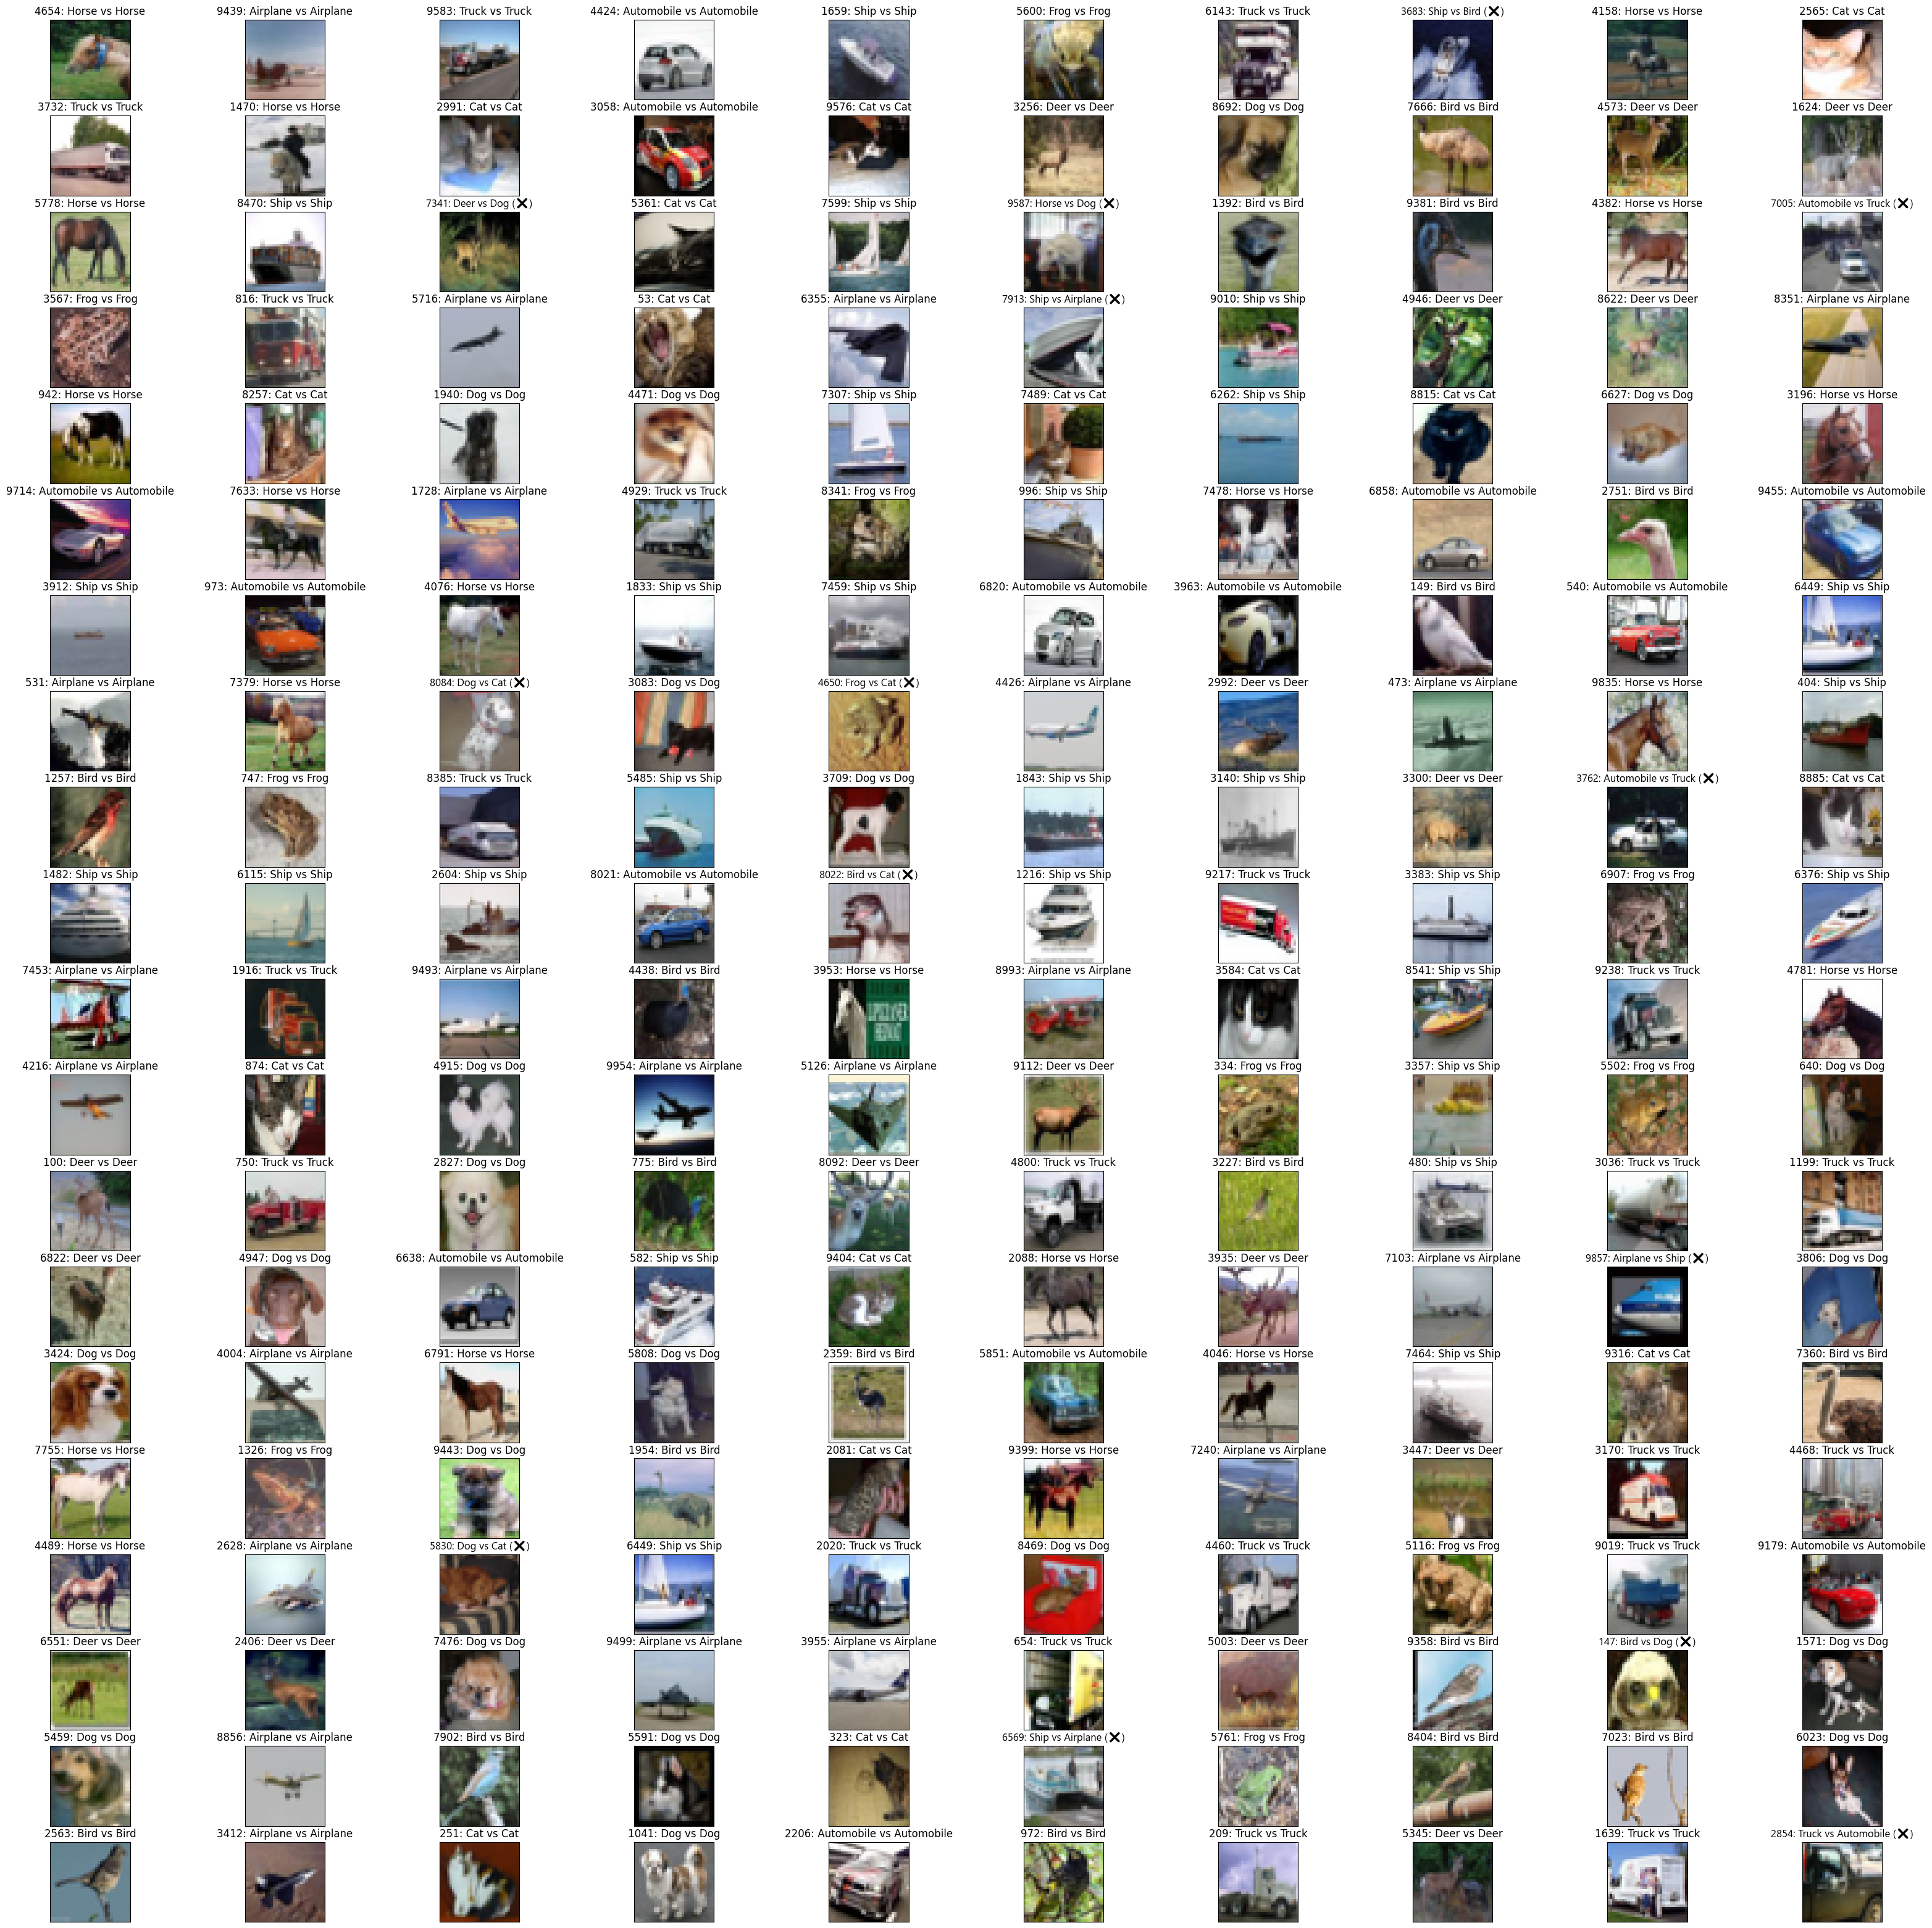

In [17]:
'''Illustrating test results'''
def illustration_test_cifar (test_size, dataset, model):
    model.eval()
    true_labels = np.zeros(test_size, dtype=int)
    predicted_labels = np.zeros(test_size, dtype=int)
    images= []

    for idx in range (test_size):
        i = np.random.randint(low=0, high= len(dataset))
        img_tensor, img_label = dataset[i] #When we __getitem__ directly frim the dataset then it is a tensor due to the transformn.ToTensor()
        true_labels[idx] = img_label
        images.append((i, img_tensor))

        with torch.no_grad():
            x = img_tensor.unsqueeze(0).to(device)
            prediction = model(x)
            predicted_labels[idx] = prediction.max(-1)[1].item()
            
    count = 0

    '''PLOTTING IMAGES'''
    print('\n RANDOM 200 IMAGES ILLUSTRATION TEST\n')
    plt.figure(figsize = (40,40))
    for idx in range (test_size):
        i, img_tensor = images[idx]
        true_label = true_labels[idx]
        pred_label = predicted_labels[idx]
        plt.subplot(test_size//10,10,idx+1)
        img_tensor = denormalize(img_tensor).clamp(0,1).cpu()
        plt.imshow(img_tensor.permute(1,2,0).cpu())
        plt.xticks([])
        plt.yticks([])

        if pred_label != true_label:
            plt.title(f'{i}: {cifar_labels[true_label]} vs {cifar_labels[pred_label]} (❌)',fontname='Segoe UI Emoji')
            print(f'Image {i} is wrong, true label: {cifar_labels[true_label]} and predicted label: {cifar_labels[pred_label]}')
        else: 
            plt.title(f'{i}: {cifar_labels[true_label]} vs {cifar_labels[pred_label]}')
            count+=1
    print(f'Correct predictions: {count} / {test_size}')
    acc = 100*count/test_size
    return acc

acc_eval = illustration_test_cifar(200, val_cifar, model)
print(f'The accuracy on random 200 datapoints is {acc_eval}%')



### View model structure and parameters

In [18]:
from torchsummary import summary
summary(model, (3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 32, 32]          --
|    └─Block: 2-1                        [-1, 64, 32, 32]          --
|    |    └─Sequential: 3-1              [-1, 64, 32, 32]          38,976
|    |    └─Sequential: 3-2              [-1, 64, 32, 32]          384
|    |    └─ReLU: 3-3                    [-1, 64, 32, 32]          --
|    └─Block: 2-2                        [-1, 64, 32, 32]          --
|    |    └─Sequential: 3-4              [-1, 64, 32, 32]          74,112
|    |    └─ReLU: 3-5                    [-1, 64, 32, 32]          --
|    └─Block: 2-3                        [-1, 64, 32, 32]          --
|    |    └─Sequential: 3-6              [-1, 64, 32, 32]          74,112
|    |    └─ReLU: 3-7                    [-1, 64, 32, 32]          --
|    └─Block: 2-4                        [-1, 64, 32, 32]          --
|    |    └─Sequential: 3-8              [-1, 64, 32, 32]          74,11

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 32, 32]          --
|    └─Block: 2-1                        [-1, 64, 32, 32]          --
|    |    └─Sequential: 3-1              [-1, 64, 32, 32]          38,976
|    |    └─Sequential: 3-2              [-1, 64, 32, 32]          384
|    |    └─ReLU: 3-3                    [-1, 64, 32, 32]          --
|    └─Block: 2-2                        [-1, 64, 32, 32]          --
|    |    └─Sequential: 3-4              [-1, 64, 32, 32]          74,112
|    |    └─ReLU: 3-5                    [-1, 64, 32, 32]          --
|    └─Block: 2-3                        [-1, 64, 32, 32]          --
|    |    └─Sequential: 3-6              [-1, 64, 32, 32]          74,112
|    |    └─ReLU: 3-7                    [-1, 64, 32, 32]          --
|    └─Block: 2-4                        [-1, 64, 32, 32]          --
|    |    └─Sequential: 3-8              [-1, 64, 32, 32]          74,11

In [22]:
from ptflops import get_model_complexity_info

model = ResNet_lite(Block, [4,4,4], num_classes=10, num_channels=3, planes=[64,128,256])
mac, params = get_model_complexity_info(model, (3,32,32),
                                        as_strings=False,
                                        print_per_layer_stat=False)
print(f"Params: {params/1e6:.2f} M")
print(f"MACs: {mac/1e9:.2f} GMac")
print(f"FLOPs: {2*mac/1e9:.2f} GFLOPs")

Params: 5.85 M
MACs: 0.84 GMac
FLOPs: 1.68 GFLOPs
